In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import mdn
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [24]:
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen

def wavenet_encode(audio):
    
    # Load the model weights.
    checkpoint_path = './wavenet-ckpt/model.ckpt-200000'
    
#     # Load and downsample the audio.
#     neural_sample_rate = 16000
#     audio = []
#     for file in file_path:
#         audio.append(utils.load_audio(audio_dir + file, 
#                                  sample_length=400000, 
#                                  sr=neural_sample_rate))
#     audio = np.vstack(audio)
#     print(audio.shape)
    
    # Pass the audio through the first half of the autoencoder,
    # to get a list of latent variables that describe the sound.
    # Note that it would be quicker to pass a batch of audio
    # to fastgen. 
    encoding = fastgen.encode(audio, checkpoint_path, len(audio))
    
    # Reshape to a single sound.
    return encoding.reshape((-1, 16))

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [5]:
audio_dir = '../ESC-50/audio/'

In [6]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [7]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [8]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [9]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [10]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [11]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [29]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 5.77428126335144
(14019, 1, 11025)


In [31]:
print(c_data.flatten().shape)

(154559475,)


In [14]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [15]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [16]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, src, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print(src.shape)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, :]
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    display.specshow(result, y_axis='linear', sr=SR)
    plt.show()
    
def evaluate_model(model, c_data):
    pred = model.predict(x=c_data)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[:, :, :, 0]
#     result = np.swapaxes(result, 1, 2)
    print(result.shape)
    return result

In [28]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.filterbank import Filterbank
import numpy as np

src = np.random.random((1, blocksize))

encodings = []
encodings.append(wavenet_encode(c_data))

UnboundLocalError: local variable 'batch_size' referenced before assignment

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, InputLayer
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [18]:
frames = mfccs

In [19]:
frames = np.expand_dims(frames, axis=3)
frames.shape

(14019, 128, 44, 1)

In [20]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_2 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

Epoch 76/100
9532/9532 [==============================] - 5s 555us/step - loss: 0.3172 - acc: 0.8512 - mean_absolute_error: 0.2189 - val_loss: 0.4822 - val_acc: 0.7831 - val_mean_absolute_error: 0.2696
Epoch 77/100
9532/9532 [==============================] - 5s 567us/step - loss: 0.3219 - acc: 0.8513 - mean_absolute_error: 0.2205 - val_loss: 0.4606 - val_acc: 0.7897 - val_mean_absolute_error: 0.2665
Epoch 78/100
9532/9532 [==============================] - 5s 558us/step - loss: 0.3143 - acc: 0.8510 - mean_absolute_error: 0.2155 - val_loss: 0.4619 - val_acc: 0.8027 - val_mean_absolute_error: 0.2686
Epoch 79/100
9532/9532 [==============================] - 5s 571us/step - loss: 0.3076 - acc: 0.8538 - mean_absolute_error: 0.2128 - val_loss: 0.4582 - val_acc: 0.7914 - val_mean_absolute_error: 0.2642
Epoch 80/100
9532/9532 [==============================] - 5s 562us/step - loss: 0.3088 - acc: 0.8560 - mean_absolute_error: 0.2135 - val_loss: 0.5021 - val_acc: 0.7825 - val_mean_absolute_erro

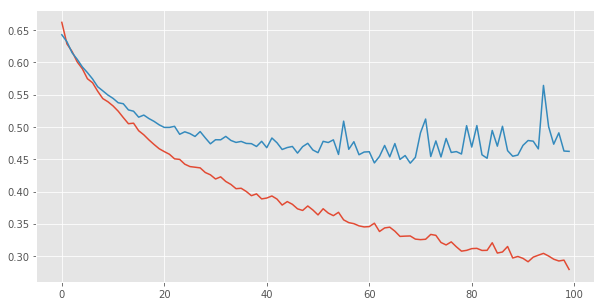

In [21]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

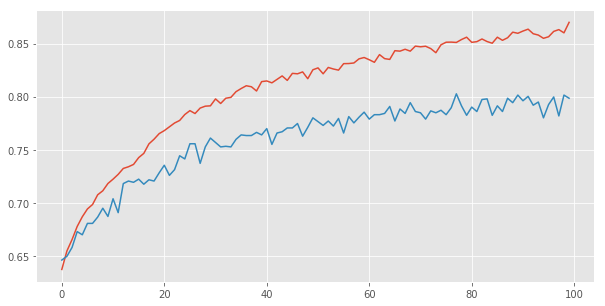

In [22]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.8202567760342369
Confusion matrix, without normalization
[[ 700  343]
 [ 161 1600]]


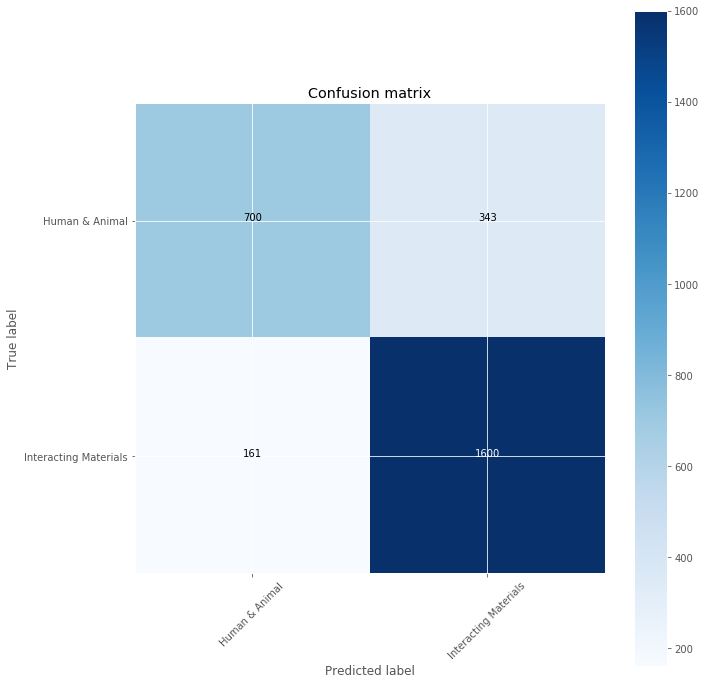

In [23]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [24]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [25]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, (3, 3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [26]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=epochs * 2, 
                       batch_size=batch, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_3 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 2, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               41088     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
__________

Epoch 71/200
3515/3515 [==============================] - 2s 573us/step - loss: 1.6034 - acc: 0.4879 - mean_absolute_error: 0.0686 - val_loss: 1.5570 - val_acc: 0.5008 - val_mean_absolute_error: 0.0668
Epoch 72/200
3515/3515 [==============================] - 2s 581us/step - loss: 1.6006 - acc: 0.4893 - mean_absolute_error: 0.0687 - val_loss: 1.5648 - val_acc: 0.5201 - val_mean_absolute_error: 0.0672
Epoch 73/200
3515/3515 [==============================] - 2s 577us/step - loss: 1.5775 - acc: 0.4950 - mean_absolute_error: 0.0682 - val_loss: 1.5273 - val_acc: 0.5072 - val_mean_absolute_error: 0.0672
Epoch 74/200
3515/3515 [==============================] - 2s 643us/step - loss: 1.5675 - acc: 0.5001 - mean_absolute_error: 0.0678 - val_loss: 1.4792 - val_acc: 0.5314 - val_mean_absolute_error: 0.0660
Epoch 75/200
3515/3515 [==============================] - 2s 577us/step - loss: 1.5447 - acc: 0.5018 - mean_absolute_error: 0.0673 - val_loss: 1.5057 - val_acc: 0.5298 - val_mean_absolute_erro

3515/3515 [==============================] - 2s 582us/step - loss: 1.2861 - acc: 0.6020 - mean_absolute_error: 0.0566 - val_loss: 1.3265 - val_acc: 0.6039 - val_mean_absolute_error: 0.0565
Epoch 152/200
3515/3515 [==============================] - 2s 629us/step - loss: 1.2528 - acc: 0.5974 - mean_absolute_error: 0.0564 - val_loss: 1.3470 - val_acc: 0.5862 - val_mean_absolute_error: 0.0576
Epoch 153/200
3515/3515 [==============================] - 2s 568us/step - loss: 1.3303 - acc: 0.5744 - mean_absolute_error: 0.0576 - val_loss: 1.3492 - val_acc: 0.5652 - val_mean_absolute_error: 0.0568
Epoch 154/200
3515/3515 [==============================] - 2s 579us/step - loss: 1.2638 - acc: 0.5858 - mean_absolute_error: 0.0572 - val_loss: 1.3468 - val_acc: 0.5765 - val_mean_absolute_error: 0.0572
Epoch 155/200
3515/3515 [==============================] - 2s 599us/step - loss: 1.2872 - acc: 0.5903 - mean_absolute_error: 0.0572 - val_loss: 1.3621 - val_acc: 0.5733 - val_mean_absolute_error: 0.0555

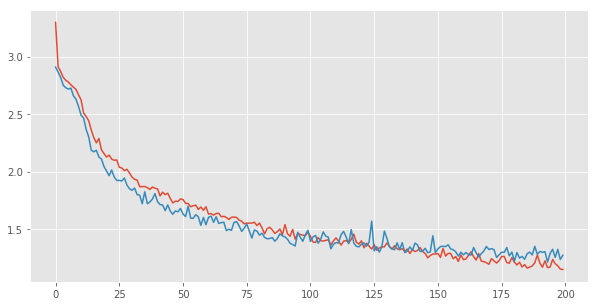

In [27]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

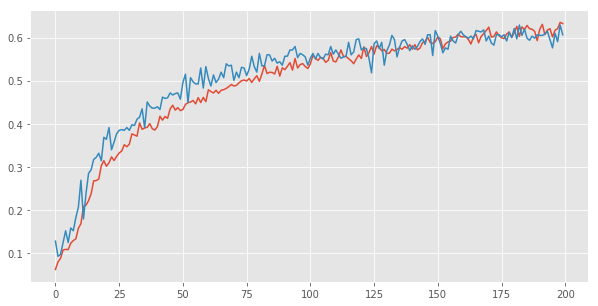

In [28]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.578743961352657
Confusion matrix, without normalization
[[34  0  1  0  0  2  2  0  0  1  0  1  0  2  0  1  1  7  1]
 [ 4 18  1  1  6  0  2  0  0  2  0  0  0  1  0  1  3  3  0]
 [ 0  0 45  0  1  0  2  1  0  0  1  1  0  0  2  1  0  1  0]
 [ 2  0  2 23  0  1  4  8  0  4  2  0  0  6  2  2  0  3  5]
 [ 0  2  0  0 32  0  0  1  0  2  0  0  0  0  4  0  1  6  0]
 [ 0  1  0  0  0 36  0  1  2  0  0  0  2  3  0  0  1  0  3]
 [ 1  0  5  0  2  2 22  2  0  2  0  1  2  0  1  9  2  5  0]
 [ 0  0  5  0  1  1  2 25  0  0  1  0  0  0  4  2  1  0  6]
 [ 4  1  0  3  8  4  1  3 43  0  0  0  2  0  1  0  0  6  2]
 [ 0  1  0  1  4  0  1  4  0 32  0  2  0  6  2  0  0  2  3]
 [ 0  0  0  0  0  0  0  4  0  0 67  1  0  0  0  0  0  0  1]
 [ 0  0  0  0  2  3  0  2  0  1  1 48  1  2  0  0  0  0  2]
 [ 2  2  5  0  1  6  6  0  2  0  0  2 15  1  2  1  2  5  7]
 [ 0  0  3  0  0  0  0  0  0  1  0  1  0 18  1  0  1  1  3]
 [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0 54  0  1  0  0]
 [ 5  0  1  0  0  0  1  3  0  0  1  0  0  

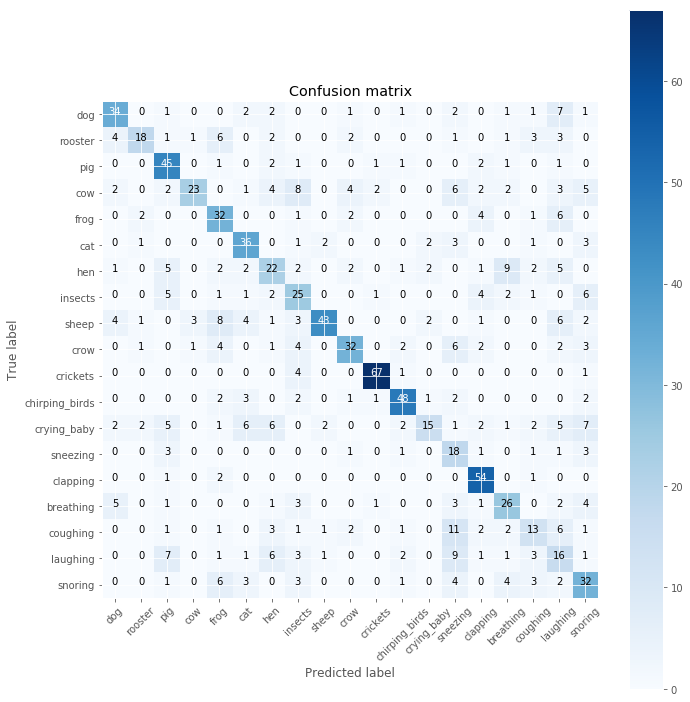

In [29]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [31]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=2.0,
        return_decibel_melgram = True,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(16, (3,3), name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Convolution2D(32, (5,2), name='conv2', activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [32]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs * 2, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 126, 42, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 16)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 1, 32)          5152      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

Epoch 71/200
6016/6016 [==============================] - 3s 497us/step - loss: 1.6838 - acc: 0.4450 - mean_absolute_error: 0.0449 - val_loss: 1.7033 - val_acc: 0.4539 - val_mean_absolute_error: 0.0439
Epoch 72/200
6016/6016 [==============================] - 3s 490us/step - loss: 1.6906 - acc: 0.4481 - mean_absolute_error: 0.0450 - val_loss: 1.6864 - val_acc: 0.4633 - val_mean_absolute_error: 0.0435
Epoch 73/200
6016/6016 [==============================] - 3s 487us/step - loss: 1.7037 - acc: 0.4448 - mean_absolute_error: 0.0448 - val_loss: 1.7028 - val_acc: 0.4510 - val_mean_absolute_error: 0.0446
Epoch 74/200
6016/6016 [==============================] - 3s 489us/step - loss: 1.6997 - acc: 0.4370 - mean_absolute_error: 0.0452 - val_loss: 1.7104 - val_acc: 0.4501 - val_mean_absolute_error: 0.0446
Epoch 75/200
6016/6016 [==============================] - 3s 494us/step - loss: 1.8216 - acc: 0.4072 - mean_absolute_error: 0.0470 - val_loss: 1.7076 - val_acc: 0.4444 - val_mean_absolute_erro

6016/6016 [==============================] - 3s 504us/step - loss: 1.4281 - acc: 0.5253 - mean_absolute_error: 0.0395 - val_loss: 1.5828 - val_acc: 0.4991 - val_mean_absolute_error: 0.0404
Epoch 152/200
6016/6016 [==============================] - 3s 533us/step - loss: 1.3829 - acc: 0.5342 - mean_absolute_error: 0.0388 - val_loss: 1.4820 - val_acc: 0.5405 - val_mean_absolute_error: 0.0377
Epoch 153/200
6016/6016 [==============================] - 3s 495us/step - loss: 1.4585 - acc: 0.5209 - mean_absolute_error: 0.0397 - val_loss: 1.5452 - val_acc: 0.5254 - val_mean_absolute_error: 0.0391
Epoch 154/200
6016/6016 [==============================] - 3s 511us/step - loss: 1.4149 - acc: 0.5249 - mean_absolute_error: 0.0395 - val_loss: 1.4932 - val_acc: 0.5254 - val_mean_absolute_error: 0.0381
Epoch 155/200
6016/6016 [==============================] - 3s 525us/step - loss: 1.4208 - acc: 0.5339 - mean_absolute_error: 0.0390 - val_loss: 1.4619 - val_acc: 0.5414 - val_mean_absolute_error: 0.0385

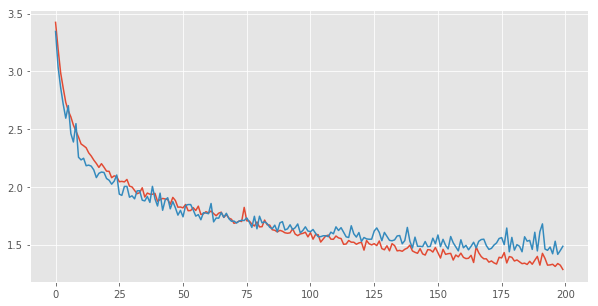

In [33]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

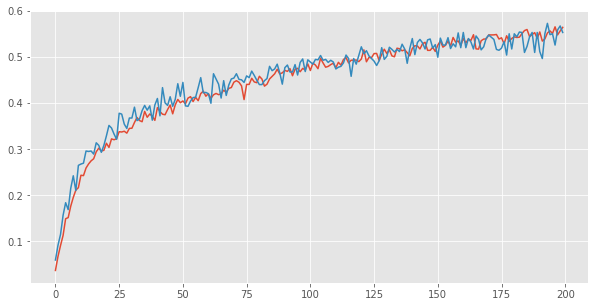

In [34]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.56045197740113
Confusion matrix, without normalization
[[44  2  0  0  3  0  3  0  0  0  0  0  0  0  0  0  2  0  0  0  0  4  0  0
   0  0  0  0  0  0  0]
 [ 0 47  0  0  2  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
   0  7  0  0  0  0  0]
 [ 0  0 42  1  0  1  0  0  3  1  0  0  0  9  0  0  0  0  0  0  0  0  0  0
   0  1  0  0  0  0  0]
 [ 0  0  0 16  0  3  0  3  1  0  0  0  2  1  0  5  0  0  7  6  2  0  0  0
   0  0  0  0  0  0  0]
 [ 5 14  0  0 36  0  1  0  0  0  0  0  0  0  0  0  0  4  1  0  0  0  2  0
   1  4  1  0  0  0  0]
 [ 0  0  2  0  0 23  0  0  3  0  0  0  0  8  0  3  0  0  2  0  1  0  0  0
   0  1  0  0  0  0  0]
 [ 1  4  1  1  0  0 24  0  1  3  0  0  0  0  0  0  4  2  1  0  0  1  2  1
   0  4  0  0  1  0  1]
 [ 0  1  1  0  2  0  0 30  3  0  0  0  1  0  0  1  0  0  0  1  0  1  0  0
   0  2  3  0 11  2  2]
 [ 0  0  5  0  0  1  1  1 28  0  1  0  3  7  0  0  0  0  0  3  0  0  0  0
   0  0  0  0  0  0  1]
 [ 0  1  8  0  0  1  8  1  2 25  2  0  0  0  1  0  0  0  2  0

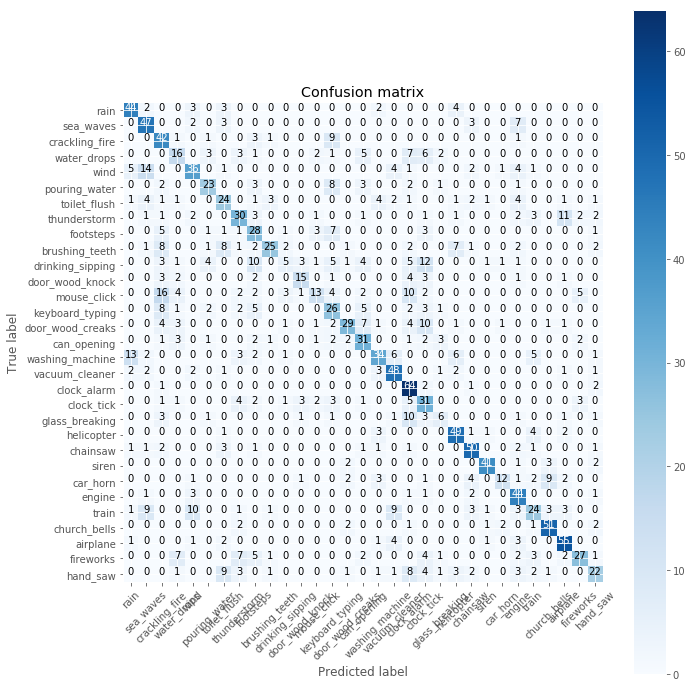

In [35]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [36]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 6.169496774673462
	Processing Time: 6.032613277435303
	Processing Time: 6.225948810577393
	Processing Time: 6.03738808631897


In [37]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [38]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [39]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


0.7196780216296192
Confusion matrix, without normalization
[[11457  9647]
 [ 6268 29402]]


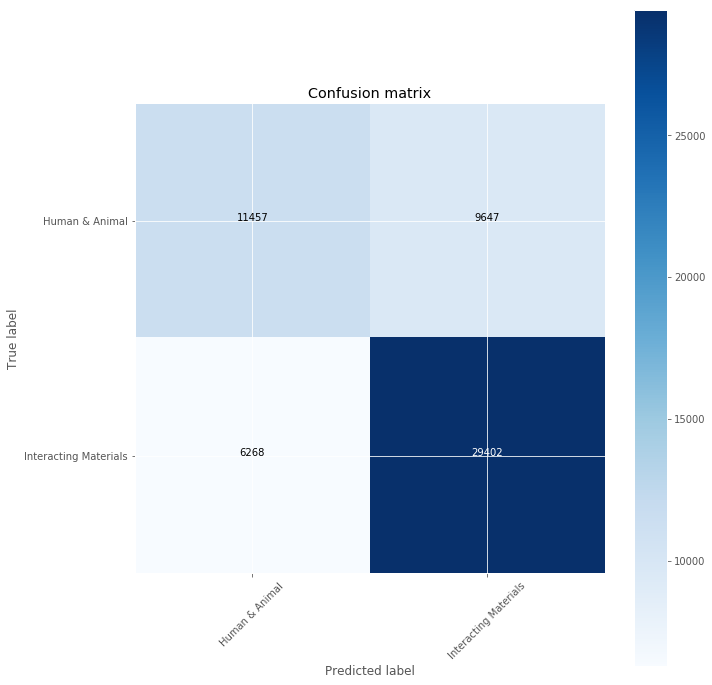

In [40]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [41]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

0.29454131918119786
Confusion matrix, without normalization
[[421  15  37  19  22  29 123   3  19  14   0   3  13  88  39  40  46 142
   34]
 [ 80 242  13  14  48  59  40   6  11  70   6   9  13 139   9  12  26  58
   30]
 [  8   3 345   6  33   8  46  54  25  44  19   9   9  10 198  22  69  83
   85]
 [104   6  28 286  19  40 266  39  63  33  20   8  24  27  17  27  15  49
   42]
 [136  34  59   8 488   4   7   0  75  35   7  55   8   8 219  18  25  43
   15]
 [116 111   9  58  31 154  37  11  32  22   9  28  21  81  28  30  38  75
  138]
 [117  17  95  27   9  43 304  35   9   8  15   7  67  14  19  81  58 170
   58]
 [ 44   0 159  50  43 126  67 351  45   7   7  19  18   7 129  41  15  15
   68]
 [ 61   5  39  62 115  37  64 109 358  68   9  35   8   8 127  25  18  38
   48]
 [ 89   3  77  37 170   3  72  40  41 261  16  23   1   4 226   6   8  25
   35]
 [ 30   0  31   3   4  10   0  68   3  72 281 487   0  41  28   9   4   0
  177]
 [ 43   2 110  13  25  22  40  30  25  16 166 526

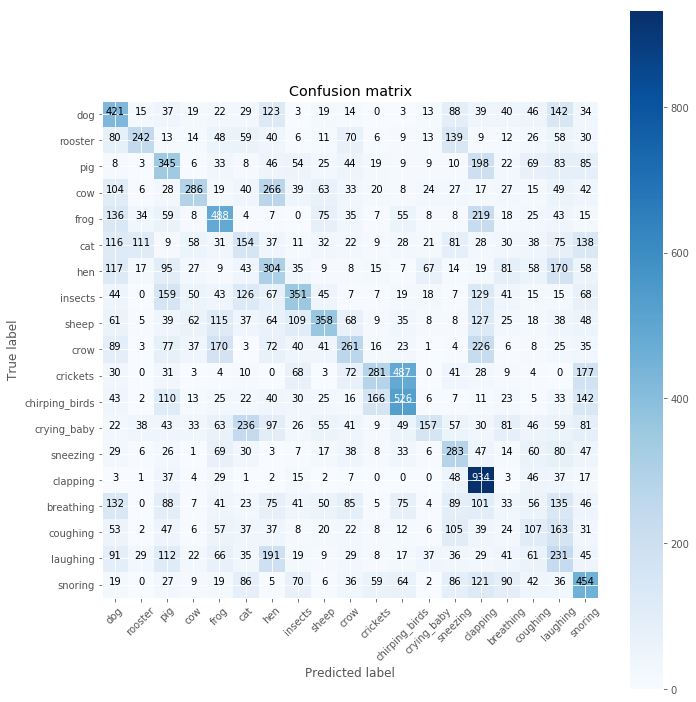

In [42]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

0.20473787496495655
Confusion matrix, without normalization
[[350  50  17   0  15   4 303  10   1   7   0   1   0   0   5   1  36  38
    0   0  10  68  43   0   0  48   0   0 232   0   9]
 [ 33 297   1   3  23   0 340   1   3   3   0   0   0   0  10   4   3  34
    5   1   1  12 201   0   0 190   7   3  45   0  22]
 [  5  11 361   1  52  73 111   4  16  40   3   1   2 118  41  31   6  13
    9  14  12  27  93   0   0 138   0   0   0  12  20]
 [  0   1  59  74   8  85  14  58  60   6  12  45  32  90  18 109   2   0
   61 161  25   0   8  13   0  13   0  11   3  38  26]
 [  0 161   0   0  78   0  10   9   2  18   1   1   0   0   1   0  24   8
    0   0   2  22  82 142  97  89 418  37   7   1  38]
 [  0   3 172  38  14 312  69   0  41  10  25  28   3 137  13  52   7   1
   67  39   8   8  83  16   2  18   0   3   0   7   5]
 [141  44  33   2  15   2 435  10  20  54   2   3  10   4   5   0  57  25
    9  23   8  71  86   4   2  59   6   3  52   2  51]
 [ 15  24   4   7  85  26  10 165  16

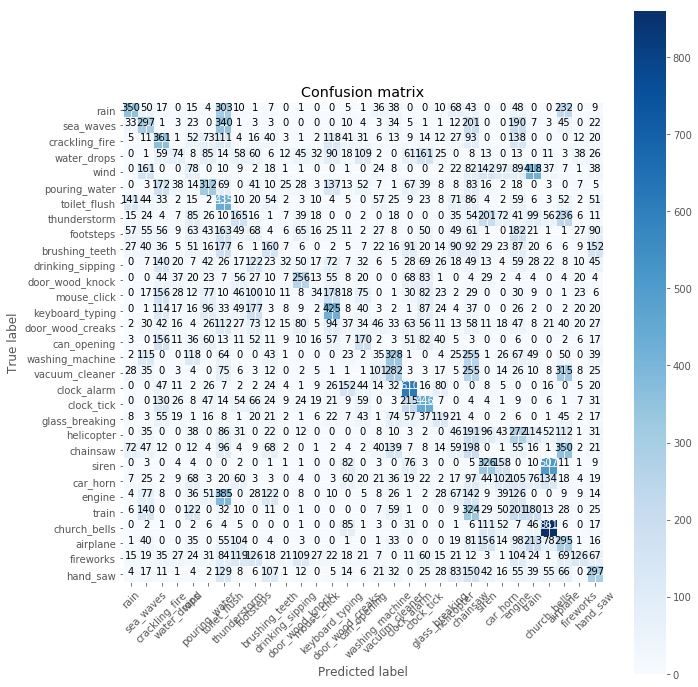

In [43]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [44]:
clas.predict_proba(X)

array([[3.4104764e-02, 9.6589524e-01],
       [4.2557716e-05, 9.9995744e-01],
       [4.9799860e-02, 9.5020014e-01],
       ...,
       [3.2384747e-01, 6.7615253e-01],
       [3.2555562e-01, 6.7444438e-01],
       [3.2540333e-01, 6.7459667e-01]], dtype=float32)

# Testing Accuracy of Single File

In [45]:
data_iloc = 1

In [46]:
def load_file_audio_blockwise(file, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    h_cat = []
    cat = []

    if debug:
        print("File Processing", end="", flush=True)
    blockgen = sf.blocks(audio_dir + file['filename'], 
                         blocksize=blocksize, 
                         overlap=overlap, 
                         always_2d=True, 
                         fill_value=0.0)
    SR = sf.info(audio_dir + file['filename']).samplerate
    for bl in blockgen:
        if not np.any(bl):
            continue
        if debug:
            print(".", end="", flush=True)
        y = bl.transpose()
        y = y[:int(blocksize)]
        y = y[np.newaxis, :]
        items.append(y)
        h_cat.append(file.h_category)
        cat.append(file.target)
    if debug:
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

In [47]:
x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)

	Processing Time: 0.014747858047485352


In [48]:
pred_prob = clas.predict_proba(x_file, verbose=1)
pred = clas.predict(x_file, verbose=1)

39/39 [==============================] - 0s 238us/step


In [49]:
np.average(pred_prob, axis=0)

array([0.8113459, 0.1886541], dtype=float32)

In [50]:
pred_prob = anim.predict_proba(x_file, verbose=1)
pred = anim.predict(x_file, verbose=1)

39/39 [==============================] - 0s 245us/step


In [51]:
np.average(pred_prob, axis=0)

array([3.4215431e-05, 7.3199724e-03, 2.7159086e-01, 2.5964153e-03,
       2.4412068e-02, 2.3919276e-03, 1.2087863e-02, 2.5723629e-02,
       3.1611673e-03, 4.9259253e-02, 1.2147191e-03, 3.5237372e-01,
       4.9433995e-02, 4.0145587e-02, 1.9435787e-03, 3.4474738e-02,
       4.4633165e-02, 5.6568641e-02, 2.0634471e-02], dtype=float32)

In [52]:
from collections import Counter
b = Counter(pred)
print(b.most_common(1)[0][0])

14


In [53]:
print(dataset.iloc[data_iloc])

filename      1-100038-A-14.wav
fold                          1
target                       14
category         chirping_birds
esc10                     False
src_file                 100038
take                          A
h_category                    0
Name: 1, dtype: object


In [54]:
predictions = []
full_targets = []
start_time = time.time()

for data_iloc in range(0,2000):
    x_file, y_file, yy_file = load_file_audio_blockwise(dataset.iloc[data_iloc],
                                                    blocksize,
                                                    overlap)
    pred = clas.predict(x_file, verbose=0)[:,0]
    b = Counter(pred)
    if b.most_common(1)[0][0] == 0:
        pred = anim.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
    else:
        pred = inter.predict(x_file, verbose=0)
        b = Counter(pred)
        predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file[0])

print("\tProcessing Time: " + str(time.time() - start_time))

	Processing Time: 0.010262489318847656
	Processing Time: 0.011761903762817383
	Processing Time: 0.013680219650268555
	Processing Time: 0.013312578201293945
	Processing Time: 0.011374711990356445
	Processing Time: 0.013896465301513672
	Processing Time: 0.009938240051269531
	Processing Time: 0.011383533477783203
	Processing Time: 0.011393070220947266
	Processing Time: 0.008246421813964844
	Processing Time: 0.008358955383300781
	Processing Time: 0.012403011322021484
	Processing Time: 0.012524604797363281
	Processing Time: 0.011359930038452148
	Processing Time: 0.007717609405517578
	Processing Time: 0.011370420455932617
	Processing Time: 0.01137232780456543
	Processing Time: 0.012605667114257812
	Processing Time: 0.022226810455322266
	Processing Time: 0.011433124542236328
	Processing Time: 0.01143503189086914
	Processing Time: 0.011414289474487305
	Processing Time: 0.012653589248657227
	Processing Time: 0.014530181884765625
	Processing Time: 0.012538671493530273
	Processing Time: 0.0125598

	Processing Time: 0.012212038040161133
	Processing Time: 0.011146783828735352
	Processing Time: 0.011953353881835938
	Processing Time: 0.011139631271362305
	Processing Time: 0.02288985252380371
	Processing Time: 0.011384725570678711
	Processing Time: 0.01266336441040039
	Processing Time: 0.011369943618774414
	Processing Time: 0.012567281723022461
	Processing Time: 0.011422872543334961
	Processing Time: 0.011382102966308594
	Processing Time: 0.009578227996826172
	Processing Time: 0.00928640365600586
	Processing Time: 0.012281179428100586
	Processing Time: 0.01140451431274414
	Processing Time: 0.012269258499145508
	Processing Time: 0.011390447616577148
	Processing Time: 0.01140141487121582
	Processing Time: 0.011430025100708008
	Processing Time: 0.011449337005615234
	Processing Time: 0.01143336296081543
	Processing Time: 0.010471820831298828
	Processing Time: 0.01232004165649414
	Processing Time: 0.011423349380493164
	Processing Time: 0.011315345764160156
	Processing Time: 0.009640455245

	Processing Time: 0.011231184005737305
	Processing Time: 0.011180400848388672
	Processing Time: 0.011243581771850586
	Processing Time: 0.011261463165283203
	Processing Time: 0.011208295822143555
	Processing Time: 0.011339426040649414
	Processing Time: 0.011166095733642578
	Processing Time: 0.011251688003540039
	Processing Time: 0.011266469955444336
	Processing Time: 0.011180877685546875
	Processing Time: 0.011189699172973633
	Processing Time: 0.011155366897583008
	Processing Time: 0.011226415634155273
	Processing Time: 0.010475635528564453
	Processing Time: 0.011244058609008789
	Processing Time: 0.011202812194824219
	Processing Time: 0.011234045028686523
	Processing Time: 0.011167764663696289
	Processing Time: 0.010782003402709961
	Processing Time: 0.011214971542358398
	Processing Time: 0.012563943862915039
	Processing Time: 0.011261224746704102
	Processing Time: 0.011150598526000977
	Processing Time: 0.012418985366821289
	Processing Time: 0.012413263320922852
	Processing Time: 0.01108

	Processing Time: 0.011208057403564453
	Processing Time: 0.010934829711914062
	Processing Time: 0.010950803756713867
	Processing Time: 0.010942935943603516
	Processing Time: 0.010946989059448242
	Processing Time: 0.013163328170776367
	Processing Time: 0.008523225784301758
	Processing Time: 0.010996818542480469
	Processing Time: 0.011106729507446289
	Processing Time: 0.011194229125976562
	Processing Time: 0.01121211051940918
	Processing Time: 0.01119542121887207
	Processing Time: 0.011220216751098633
	Processing Time: 0.011182308197021484
	Processing Time: 0.011197566986083984
	Processing Time: 0.009283065795898438
	Processing Time: 0.01008462905883789
	Processing Time: 0.009604454040527344
	Processing Time: 0.011114120483398438
	Processing Time: 0.012187719345092773
	Processing Time: 0.010029315948486328
	Processing Time: 0.011156082153320312
	Processing Time: 0.011187553405761719
	Processing Time: 0.011203527450561523
	Processing Time: 0.011111736297607422
	Processing Time: 0.01239204

	Processing Time: 0.012095451354980469
	Processing Time: 0.010911226272583008
	Processing Time: 0.01111459732055664
	Processing Time: 0.011720657348632812
	Processing Time: 0.011142253875732422
	Processing Time: 0.012221097946166992
	Processing Time: 0.011083126068115234
	Processing Time: 0.011078834533691406
	Processing Time: 0.011070966720581055
	Processing Time: 0.011115550994873047
	Processing Time: 0.01115274429321289
	Processing Time: 0.011106729507446289
	Processing Time: 0.011325359344482422
	Processing Time: 0.011141300201416016
	Processing Time: 0.01106572151184082
	Processing Time: 0.011120796203613281
	Processing Time: 0.011075019836425781
	Processing Time: 0.010912895202636719
	Processing Time: 0.011128902435302734
	Processing Time: 0.011161327362060547
	Processing Time: 0.01112675666809082
	Processing Time: 0.008583784103393555
	Processing Time: 0.011102437973022461
	Processing Time: 0.011111736297607422
	Processing Time: 0.011096954345703125
	Processing Time: 0.011115789

	Processing Time: 0.012297630310058594
	Processing Time: 0.011052370071411133
	Processing Time: 0.011059045791625977
	Processing Time: 0.011064529418945312
	Processing Time: 0.011098623275756836
	Processing Time: 0.011098146438598633
	Processing Time: 0.008692741394042969
	Processing Time: 0.00985407829284668
	Processing Time: 0.008602380752563477
	Processing Time: 0.008275508880615234
	Processing Time: 0.011041402816772461
	Processing Time: 0.011120080947875977
	Processing Time: 0.011122941970825195
	Processing Time: 0.011064529418945312
	Processing Time: 0.011142253875732422
	Processing Time: 0.011097908020019531
	Processing Time: 0.01098012924194336
	Processing Time: 0.01091456413269043
	Processing Time: 0.010994195938110352
	Processing Time: 0.010095596313476562
	Processing Time: 0.011105060577392578
	Processing Time: 0.011142730712890625
	Processing Time: 0.010612010955810547
	Processing Time: 0.010187387466430664
	Processing Time: 0.009678125381469727
	Processing Time: 0.02102923

	Processing Time: 0.009465217590332031
	Processing Time: 0.011199474334716797
	Processing Time: 0.011121749877929688
	Processing Time: 0.011086702346801758
	Processing Time: 0.011064767837524414
	Processing Time: 0.011206388473510742
	Processing Time: 0.011149406433105469
	Processing Time: 0.011242866516113281
	Processing Time: 0.009097576141357422
	Processing Time: 0.011094093322753906
	Processing Time: 0.011106729507446289
	Processing Time: 0.017473220825195312
	Processing Time: 0.011187553405761719
	Processing Time: 0.011054515838623047
	Processing Time: 0.01111602783203125
	Processing Time: 0.01111149787902832
	Processing Time: 0.011113643646240234
	Processing Time: 0.011152982711791992
	Processing Time: 0.011140108108520508
	Processing Time: 0.011095285415649414
	Processing Time: 0.01116633415222168
	Processing Time: 0.011164188385009766
	Processing Time: 0.008079767227172852
	Processing Time: 0.011153936386108398
	Processing Time: 0.008718013763427734
	Processing Time: 0.01110529

	Processing Time: 0.011015892028808594
	Processing Time: 0.011085987091064453
	Processing Time: 0.011076688766479492
	Processing Time: 0.011081457138061523
	Processing Time: 0.008853435516357422
	Processing Time: 0.011106729507446289
	Processing Time: 0.011047601699829102
	Processing Time: 0.011194944381713867
	Processing Time: 0.011080265045166016
	Processing Time: 0.011008739471435547
	Processing Time: 0.011051177978515625
	Processing Time: 0.011061668395996094
	Processing Time: 0.011104822158813477
	Processing Time: 0.011097908020019531
	Processing Time: 0.011157512664794922
	Processing Time: 0.011000394821166992
	Processing Time: 0.008046150207519531
	Processing Time: 0.011075735092163086
	Processing Time: 0.011179924011230469
	Processing Time: 0.011088132858276367
	Processing Time: 0.011099576950073242
	Processing Time: 0.009144306182861328
	Processing Time: 0.007804393768310547
	Processing Time: 0.014161109924316406
	Processing Time: 0.008330821990966797
	Processing Time: 0.00951

	Processing Time: 0.011176824569702148
	Processing Time: 0.0111083984375
	Processing Time: 0.011087417602539062
	Processing Time: 0.011209487915039062
	Processing Time: 0.011110782623291016
	Processing Time: 0.01119375228881836
	Processing Time: 0.01109766960144043
	Processing Time: 0.011043548583984375
	Processing Time: 0.018896102905273438
	Processing Time: 0.011246919631958008
	Processing Time: 0.011169195175170898
	Processing Time: 0.011150121688842773
	Processing Time: 0.011136054992675781
	Processing Time: 0.011190652847290039
	Processing Time: 0.011160135269165039
	Processing Time: 0.011137723922729492
	Processing Time: 0.011173486709594727
	Processing Time: 0.011124134063720703
	Processing Time: 0.011233091354370117
	Processing Time: 0.011192083358764648
	Processing Time: 0.011190414428710938
	Processing Time: 0.011223793029785156
	Processing Time: 0.011182069778442383
	Processing Time: 0.011156082153320312
	Processing Time: 0.011208772659301758
	Processing Time: 0.011239051818

	Processing Time: 0.011138200759887695
	Processing Time: 0.011100053787231445
	Processing Time: 0.011121034622192383
	Processing Time: 0.011138200759887695
	Processing Time: 0.010976791381835938
	Processing Time: 0.010970354080200195
	Processing Time: 0.012412071228027344
	Processing Time: 0.012896060943603516
	Processing Time: 0.01147913932800293
	Processing Time: 0.012465953826904297
	Processing Time: 0.011086463928222656
	Processing Time: 0.011009454727172852
	Processing Time: 0.010987043380737305
	Processing Time: 0.011003971099853516
	Processing Time: 0.01093912124633789
	Processing Time: 0.011005878448486328
	Processing Time: 0.010989904403686523
	Processing Time: 0.010936260223388672
	Processing Time: 0.01071619987487793
	Processing Time: 0.010806083679199219
	Processing Time: 0.010967493057250977
	Processing Time: 0.01806926727294922
	Processing Time: 0.007645368576049805
	Processing Time: 0.011066913604736328
	Processing Time: 0.011159896850585938
	Processing Time: 0.011019945

In [55]:
print(full_targets)
targs = np.vstack(full_targets)

[0, 14, 36, 36, 19, 19, 30, 34, 9, 30, 30, 22, 22, 22, 0, 22, 19, 48, 48, 48, 48, 22, 22, 22, 41, 47, 31, 17, 45, 8, 15, 15, 15, 46, 46, 37, 32, 16, 37, 25, 25, 25, 25, 25, 25, 4, 4, 48, 48, 3, 15, 27, 27, 43, 12, 40, 40, 40, 40, 40, 40, 29, 10, 12, 7, 12, 12, 12, 26, 4, 6, 6, 40, 40, 44, 44, 23, 31, 20, 4, 4, 4, 49, 43, 24, 24, 7, 8, 8, 36, 36, 36, 41, 41, 41, 39, 3, 28, 18, 2, 2, 2, 2, 2, 20, 20, 20, 10, 46, 35, 38, 38, 25, 20, 20, 46, 44, 15, 15, 19, 19, 49, 35, 35, 43, 43, 19, 19, 19, 47, 43, 48, 48, 2, 2, 2, 21, 43, 43, 30, 10, 1, 35, 35, 28, 28, 1, 18, 11, 11, 43, 16, 10, 21, 26, 26, 18, 0, 0, 23, 23, 23, 24, 6, 6, 42, 42, 21, 4, 4, 0, 35, 35, 29, 26, 5, 5, 1, 1, 14, 14, 37, 38, 26, 26, 23, 23, 23, 23, 47, 29, 14, 14, 9, 9, 11, 11, 1, 28, 46, 28, 1, 28, 34, 12, 38, 1, 11, 34, 47, 47, 47, 47, 1, 27, 31, 14, 12, 18, 49, 36, 7, 7, 41, 41, 21, 21, 16, 16, 5, 5, 5, 28, 46, 38, 35, 8, 8, 10, 44, 44, 15, 17, 44, 17, 16, 16, 16, 25, 18, 17, 17, 33, 33, 33, 33, 33, 33, 33, 33, 24, 30, 24,

0.2365
Confusion matrix, without normalization
[[16  0  1 ...  0  0  0]
 [ 0 16  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  1]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  4  1  2]
 [ 0  0  2 ...  1  0 12]]


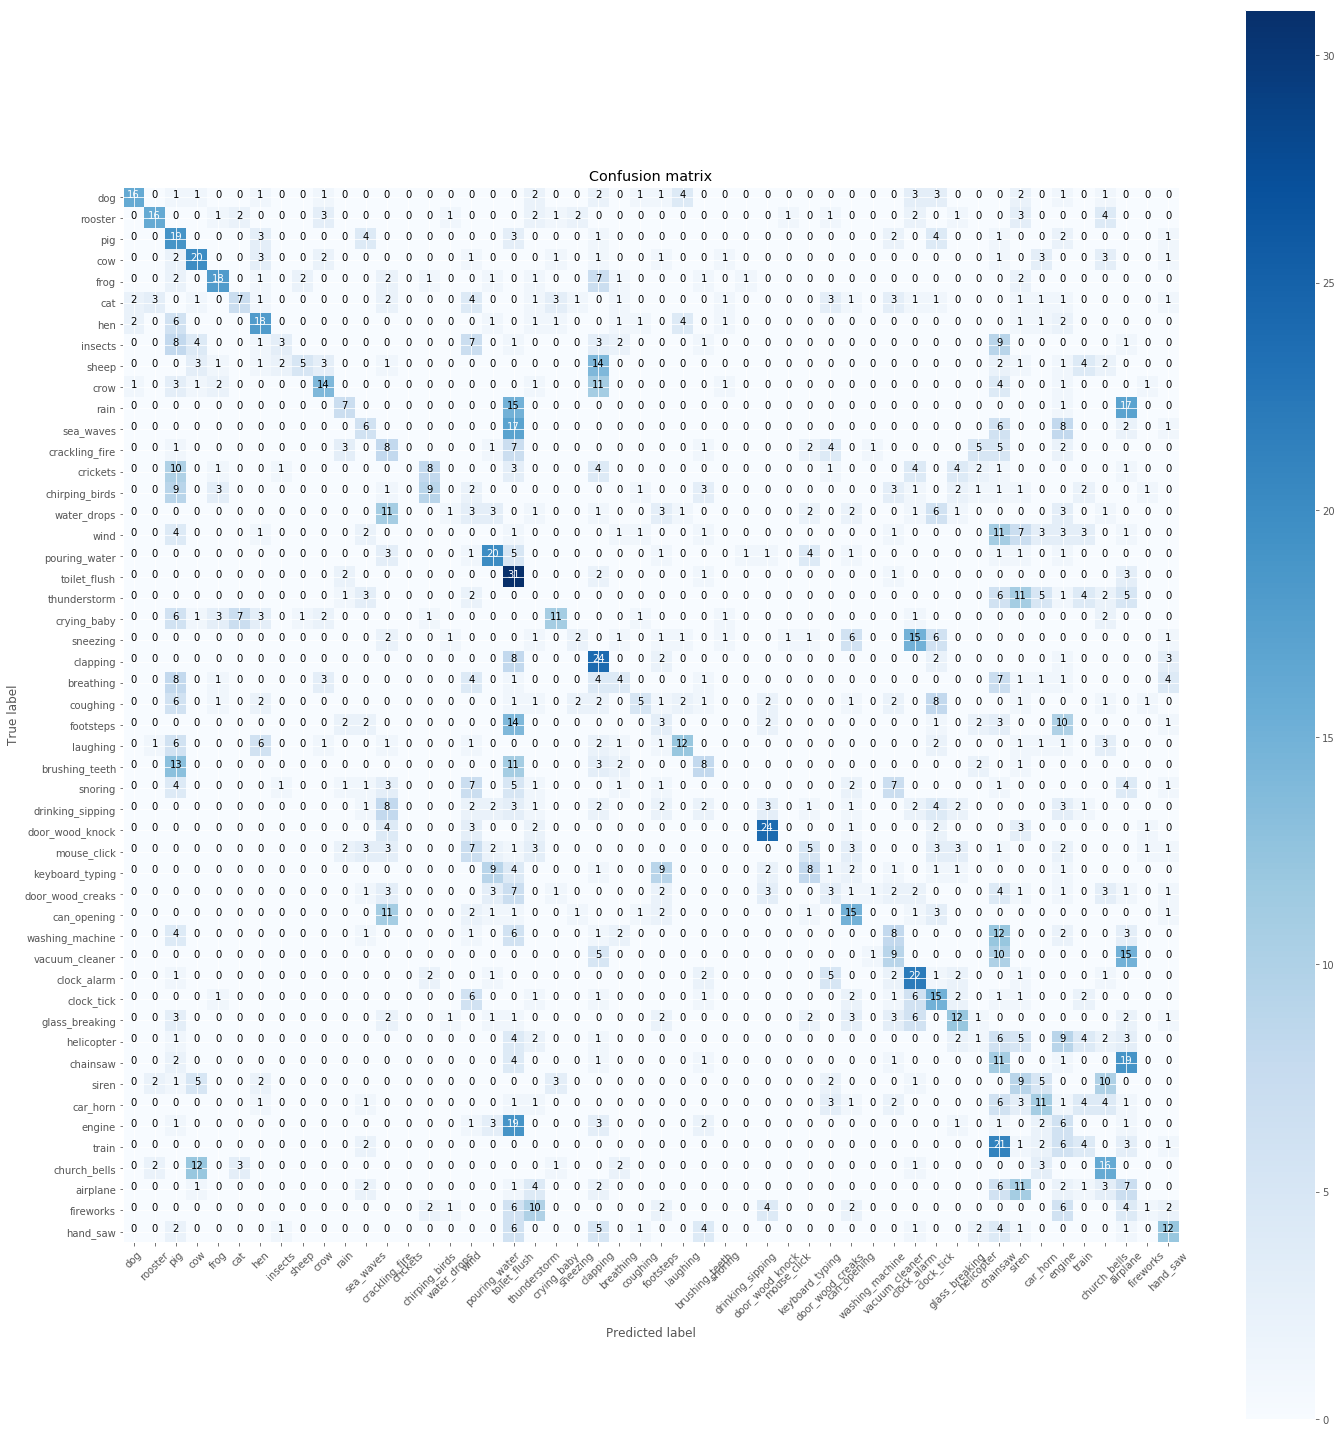

In [57]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()